# AIM CIPS Gravity Wave Identification

For information on GLCM Texture features:
https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

Using texture analysis for sea ice identification:
https://www.asprs.org/wp-content/uploads/pers/1991journal/apr/1991_apr_385-395.pdf

In [1]:
import os
import imageio
import itertools
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from ipywidgets import interact, interact_manual
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 15})

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
image_path = '../../data/north_2016/l2a/scene_images/'
image_list = [os.path.join(image_path, f) for f in os.listdir(image_path)]

## Data

I hand-labeled data in a CSV with what I thought were wave-like features, however, this step should be re-done by somebody who has more knowledge of gravity waves for better accuracy.

Labels:
* 0 - nothing noteable
* 1 - wave-like
* 2 - red noisy
* 5 - bad pixels
* 6 - red/blue split
* 7 - other

In [3]:
# These are the hand-labeled data
data_txt = pd.read_csv('corr_diss_v0.txt', delimiter=',')
corr_all = np.array(data_txt['correlation'])
diss_all = np.array(data_txt['dissimilarity'])
file_all = np.array(data_txt['file'])

In [4]:
df = pd.read_csv('labels_final.csv')

# Choose the first 1000 
df['Dissimilarity'] = diss_all[0:1000]
df['Correlation'] = corr_all[0:1000]

# Get rid of anything labeled as anomalous
df = df[df.label < 2]

## Data Exploration



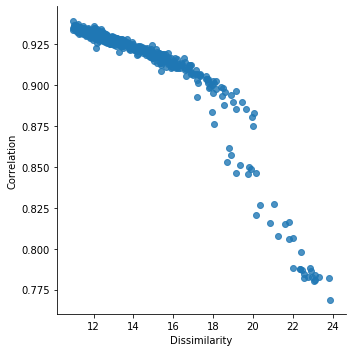

In [5]:
# Plot of correlation vs dissimilarity 
sns.lmplot('Dissimilarity', 'Correlation', data=df, fit_reg=False)

In [6]:
# Create input and output arrays
y = np.array(df['label'])
X = np.array(df[['Dissimilarity', 'Correlation']])

In [7]:
# Split into training and testing sets. To change the size of the test set, change test_size.
# test_size = 0.3 determined be experimenting with different sizes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Classifier Training and Fitting

I tried a few classifiers, but Random Forest did the best on this particular problem. You can see more about random forest here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [8]:
# Plotting code for confusion matrix, adapted from sklearn plot_confusion_matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    plt.show()

Score:  0.921161825726141
Confusion matrix:  [[216   9]
 [ 10   6]]
Normalized confusion matrix


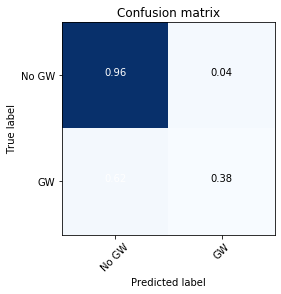

In [9]:
# Train without addressing the class imbalance
class_names = ['No GW', 'GW']
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Score: ', clf.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix: ', cm)
plot_confusion_matrix(cm, classes=class_names, normalize=True, 
                      title='Confusion matrix', cmap=plt.cm.Blues)

## Class Imbalance

Notice that without addressing the class imbalance, the "score" is very high, but the classifier is not actually doing well at classifying the few gravity wave images it has seen. We need to address the class imbalance so that the classifier can perform better on the minority class. To do this, I used SMOTE, which you can read more about here: https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html

In [10]:
sm = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

Score:  0.8598130841121495
Confusion matrix:  [[255  33]
 [ 12  21]]
Normalized confusion matrix


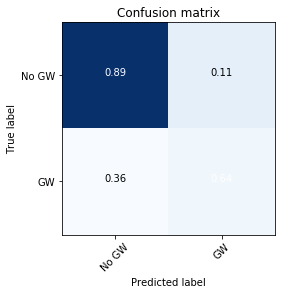

In [11]:
# Train with addressing the class imbalance
class_names = ['No GW', 'GW']
clf = RandomForestClassifier()
clf.fit(X_res, y_res)
y_pred = clf.predict(X_test)
print('Score: ', clf.score(X_test, y_test))
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix: ', cm)
plot_confusion_matrix(cm, classes=class_names, normalize=True, 
                      title='Confusion matrix', cmap=plt.cm.Blues)

## Inspect the Data

In [12]:
# You can change this filter to look at whatever data you find interesting
filt = df[(df['Correlation'] > 0.875) & (df['Dissimilarity'] > 18)].index

In [13]:
# This interactive plot will show you the images that match the filter above
@interact
def show_images(index = np.array(filt)):
    print(df['filename'][index])
    print('Correlation: ', df['Correlation'][index])
    print('Dissimilarity: ', df['Dissimilarity'][index])
    im = imageio.imread(df['filename'][index])
    plt.imshow(im, cmap=plt.cm.gray)

interactive(children=(Dropdown(description='index', options=(37, 80, 124, 188, 225, 296, 320, 352, 493, 494, 5…